[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Unsupervised learning with Autoencoder

We first play with MNIST dataset and pieces of code seen during the course.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

## Loading MNIST

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [3]:
# to be modified if not on colab
ROOT_DIR = Path.home()
root_dir = os.path.join(ROOT_DIR,'data/MNIST/')
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

## Helper Functions

In [4]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [6]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

Why did we take 784 as input dimension?

To find the learning rate, see the documentation for [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [7]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [8]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.115747
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.042300
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.029053
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.026450
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.022755
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.020759
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.019185
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.017647
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.017365
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.017214
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.015421
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.016300
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.015545
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.015277
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.015515
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.014834
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.015397
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.015041
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.014665
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.014947
Train Epoch: 6 [51200/60000 (85%)]	

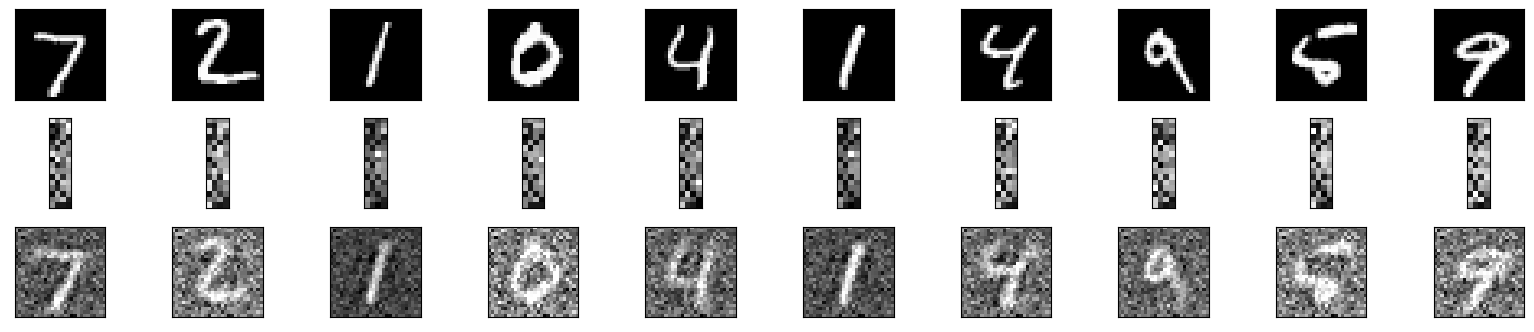

In [9]:
plot_reconstructions(model)

## 1. Exercise: Stacked Autoencoder

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and then the code of dimension 32. For the decoder, you can take the same sequence of dimensions in reverse order.

In [10]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, encoding_dim), 
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, input_dim),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [12]:
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.119134
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.046707
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.035226
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.031709
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.026442
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.026852
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.025428
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.024838
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.022738
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.022698
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.020965
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.020780
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.020733
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.019748
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.019937
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.019511
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.019901
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.018983
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.017897
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.018193
Train Epoch: 6 [51200/60000 (85%)]	

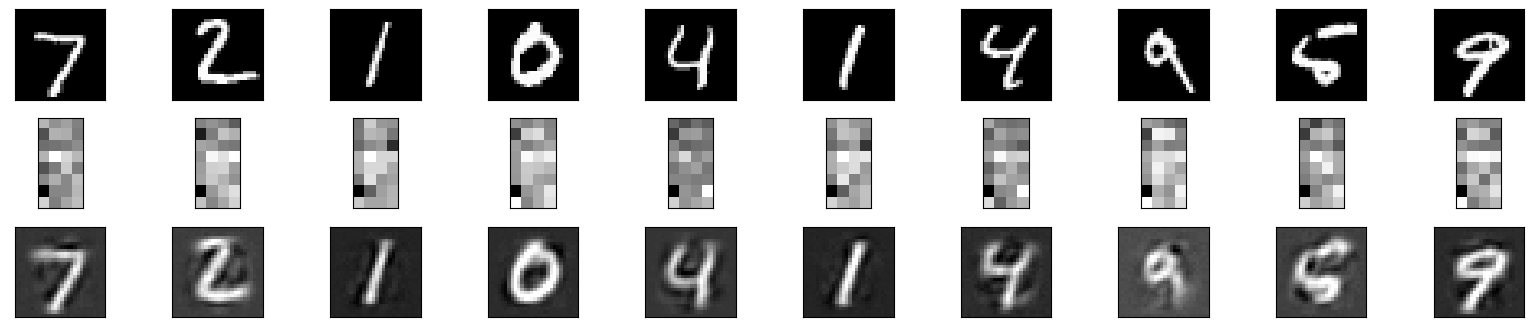

In [13]:
plot_reconstructions(model)

Replace the `MSELoss` with a `BCEWithLogitsLoss` for each pixel. Note the unusual use of `BCEWithLogitsLoss`! You can have a look at the definition of [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy).

In [14]:
model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn =torch.nn.BCEWithLogitsLoss()
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.693143
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.264091
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.235814
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.222988
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.180981
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.168432
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.157009
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.153685
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.150155
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.145204
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.145537
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.139597
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.137051
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.139092
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.130121
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.128944
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.129203
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.126364
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.125999
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.127309
Train Epoch: 6 [51200/60000 (85%)]	

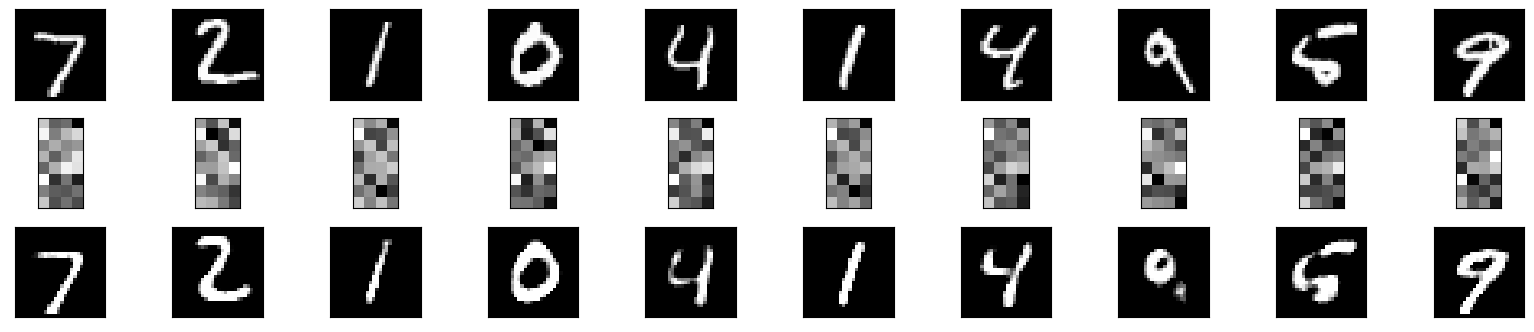

In [15]:
plot_reconstructions(model)

## 2. Optional

At this stage, you can code the interpolation described in the lesson to obtain:

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/interp_AE.png)

In [42]:
data, labels = next(iter(test_loader))
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [43]:
encoded_0 = model.encoder(data[1].view(-1,784).to(device))
encoded_1 = model.encoder(data[9].view(-1,784).to(device))

In [44]:
alpha = torch.linspace(0,1,steps=10)
alpha = alpha.view(-1,1).to(device)
interp = (1-alpha)*encoded_0+alpha*encoded_1

In [45]:
decoded_imgs = model.decoder(interp)

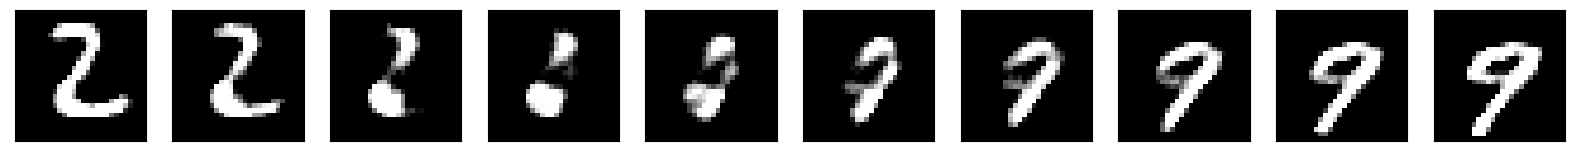

In [46]:
decoded_imgs = to_img(decoded_imgs)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [47]:
#encoded_0 = model.encoder(data[0].view(-1,784).to(device))
#encoded_1 = model.encoder(data[6].view(-1,784).to(device))
n = 100
alpha = torch.linspace(0,1,steps=n)
alpha = alpha.view(-1,1).to(device)
interp = (1-alpha)*encoded_0+alpha*encoded_1
decoded_imgs = model.decoder(interp)
decoded_imgs = to_img(decoded_imgs)

In [48]:
import matplotlib.animation as animation

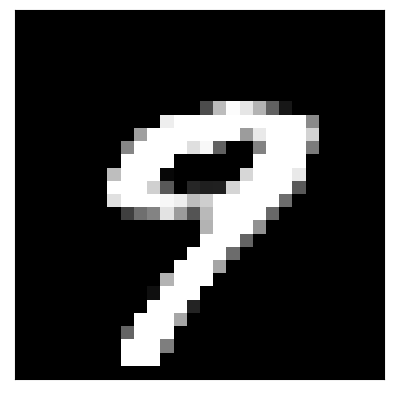

In [50]:
fig, ax = plt.subplots()
ims = []
for i in range(len(decoded_imgs)):
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    im = ax.imshow(decoded_imgs[i], animated=True)
    if i == 0:
        ax.imshow(decoded_imgs[0])  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
#writergif = animation.PillowWriter(fps=30) 
#ani.save("AE_interpolate.gif",writer=writergif)
plt.show()

# 3. Exercise: Implement a denoising AE:


Use previous code and with minimal modifications, transform your AE in a denoising AE. Now, you first apply some noise to your input and try to recover the original data at the output. For the noise, you can add some random noise or erase some of the pixels. In this last case, you should obtain something like: 

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/denoising_AE.png)

The first line corresponds to the original digit, the second line to the noisy version of the digit given as input to your network, the third line is the associated code and the last line is the denoised digit obtained by your decoder from the code.

In [62]:
# You need first to modify the training process by adding noise to your data
# Hint if you want to erase pixels: https://stackoverflow.com/questions/49216615/is-there-an-efficient-way-to-create-a-random-bit-mask-in-pytorch
def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            mask = torch.empty_like(data).uniform_() > noise
            noisy_data = data * mask#data + noise*torch.randn(data.size())
            data = data.view([-1, 784]).to(device)
            noisy_data = noisy_data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

In [63]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [64]:
train_denoiser(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer, noise=0.8)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.694863
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.264086
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.251885
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.257377
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.241542
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.233211
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.220462
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.198248
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.193567
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.188384
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.179959
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.175342
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.177002
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.169919
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.171419
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.165884
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.164120
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.161787
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.168315
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.160772
Train Epoch: 6 [51200/60000 (85%)]	

In [65]:
# Now you need to modify the plot function
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits, 
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    #
    # your code here to compute
    # noisy_data
    # encoded_imgs
    # decoded_imgs
    mask = torch.empty_like(data).uniform_() > noise
    noisy_data = mask * data
    #data += noise * torch.randn(data.size())
    data = data.to(device)
    noisy_data = noisy_data.to(device)
    noisy_data.requires_grad = False
    data = data.view([-1, 784])
    noisy_data = noisy_data.view([-1,784])
    encoded_imgs = model.encoder(noisy_data)
    decoded_imgs = model.decoder(encoded_imgs)
    #
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

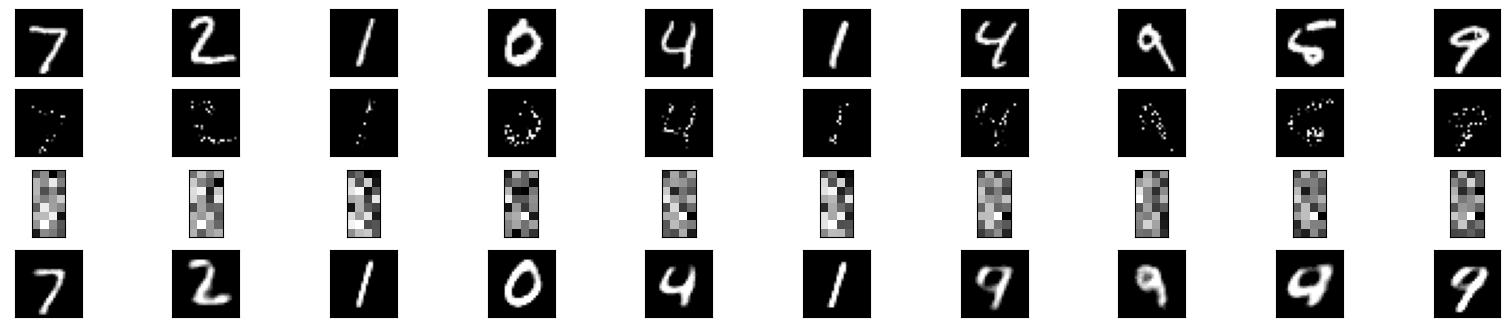

In [66]:
plot_denoising(model, noise=0.8)

# 4. Optional: how to deal with convolutions?

Hint: start by decreasing the size of your image with `Conv2d` by using a `stride` like:

In [67]:
conv = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2)
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

torch.Size([2, 16, 32, 32])

Now use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (or [deconvolution](https://distill.pub/2016/deconv-checkerboard/)) with the same parameters:

In [68]:
convt = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, stride=2)

In [69]:
convt(y).shape

torch.Size([2, 8, 63, 63])

To get the same size as `x`, play with `output_padding`.

Now, you have all the tools to build a convolutional autoencoder!

In [70]:
class Conv_AutoEncoder(nn.Module):
    def __init__(self):
        super(Conv_AutoEncoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [71]:
def train_model_conv(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            #data = data.view([-1, 784]).to(device)\
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [72]:
model = Conv_AutoEncoder()
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [73]:
data, _ = next(iter(test_loader))
data = data.to(device)

In [74]:
model(data).shape

torch.Size([10, 1, 28, 28])

In [75]:
train_model_conv(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.691872
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.220929
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.092792
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.085631
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.079558
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.076335
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.073393
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.071462
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.069728
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.070443
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.069396
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.069268
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.067972
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.067337
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.065909
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.068754
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.066187
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.064060
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.066051
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.065791
Train Epoch: 6 [51200/60000 (85%)]	

In [78]:
class Conv_Up(nn.Module):
    def __init__(self):
        super(Conv_Up, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, 3, stride=3, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=3, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [79]:
model = Conv_Up()
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [80]:
def train_model_up(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(F.avg_pool2d(data, kernel_size = 2))
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [81]:
train_model_up(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.652137
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.272509
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.196397
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.168208
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.126253
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.108091
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.102734
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.094501
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.093328
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.092811
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.088705
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.084002
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.081608
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.081535
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.081529
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.081876
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.077226
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.080878
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.080453
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.077473
Train Epoch: 6 [51200/60000 (85%)]	

In [84]:
def to_img(x, size=28):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, size, size])
    return x

def plot_up_conv(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    #mask = torch.zeros_like(data)
    #mask[:,:,-level:,:] = torch.ones(10,1,level,28)
    #noisy_data = mask * data
    noisy_data = F.avg_pool2d(data, kernel_size = 2)
    #data += noise * torch.randn(data.size())
    data = data.to(device)
    noisy_data = noisy_data.to(device)
    
    #data = data.view([-1, 784])
    #noisy_data = noisy_data.view([-1,784])
    noisy_data.requires_grad = False
    encoded_imgs = model.encoder(noisy_data)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data, size=14)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()

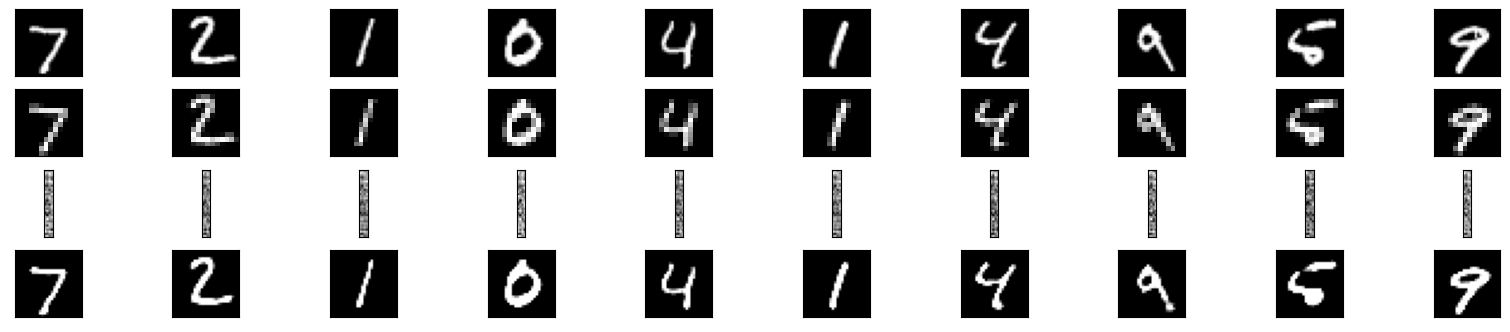

In [85]:
plot_up_conv(model)

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)